## Another Sentiment Analysis Solution

### Step 1: Define imports

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.callbacks import CallbackAny2Vec
import logging

import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

%matplotlib inline

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adeid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adeid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\adeid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Step 2: Define global constants and variables

In [47]:
DATA_DIR = "data/"
SENTIMENT_DATA_1 = f"{DATA_DIR}financial_sentiment_data.csv"
SENTIMENT_DATA_2 = f"{DATA_DIR}fiqa_and_finacial_phrase_bank_dataset.csv"
WORD_2_VEC_MODEL_PATH = "./models/GoogleNews-vectors-negative300.bin"
ENCODING = "ISO-8859-1"
RANDOM_SEED = 100
IS_USE_KEY_VECTORS = True

### Step 3: Get the data

In [64]:
def get_financial_sentiment_data(is_fiqa_data: bool=False):
    """
    Gets the financial sentiment data
    :param is_fiqa_data: Flag to indicate if the data is "FIQA and Phrase bank" related
    :returns: financial sentiment dataset
    """
    financial_sentiment_data_path = SENTIMENT_DATA_2 if is_fiqa_data else SENTIMENT_DATA_1
    df = pd.read_csv(financial_sentiment_data_path, encoding = ENCODING)
    df = df.reindex(np.random.permutation(df.index))
    if is_fiqa_data:
        df.rename(columns={"Sentence": "text", "Sentiment": "sentiment"}, inplace=True)
        df['sentiment'] = df['sentiment'].map({'neutral': 0, 'positive': 1, 'negative': 2})
        return df
    else:
        df = df[['sentiment', 'text']]
        df['sentiment'] = df['sentiment'].map({'neutral': 0, 'positive': 1, 'negative': 2})
        df_reordered = df.iloc[:, [1, 0]]
        return df_reordered


df = get_financial_sentiment_data()
#df = get_financial_sentiment_data(True)


In [65]:
df.head()

,text,sentiment
3772,The bridge is part of the highway 14 developme...,0
1423,The shares carry a right to dividend and other...,0
1042,"Headquartered in this city , the company is ne...",0
4075,The poorest index figure was given to Finnish ...,2
2199,The actions are expected to deliver annual cos...,1


### Step 4: Text Preprocessing
- Clean the text data by removing punctuation, converting to lowercase, and removing stop words.

In [66]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)

# Apply preprocessing
df['clean_text'] = df['text'].apply(preprocess_text)


In [67]:
df.head()

,text,sentiment,clean_text
3772,The bridge is part of the highway 14 developme...,0,bridge part highway development project
1423,The shares carry a right to dividend and other...,0,shares carry right dividend shareholder rights...
1042,"Headquartered in this city , the company is ne...",0,headquartered city company nearly years old fo...
4075,The poorest index figure was given to Finnish ...,2,poorest index figure given finnish power compa...
2199,The actions are expected to deliver annual cos...,1,actions expected deliver annual cost savings


In [68]:
df.text[100]

'Both operating profit and turnover for the three-month period increased , respectively from EUR0 .9 m and EUR8 .3 m , as compared to the corresponding period in 2005 .'

### Step 5: Generate Word Embeddings (Word2Vec)

In [69]:
          
# Assuming 'df' has a 'clean_text' column
texts = [word_tokenize(text) for text in df['clean_text']]

if IS_USE_KEY_VECTORS:
    # Or load a pre-trained model (e.g., GoogleNews-vectors-negative300.bin)
    key_vectors_w2v = KeyedVectors.load_word2vec_format(WORD_2_VEC_MODEL_PATH, binary=True, limit=200000) 
else:
    # Train a Word2Vec model (adjust parameters as needed)
    model_w2v = Word2Vec(sentences=texts, vector_size=100, window=5, min_count=1, workers=4, seed=RANDOM_SEED)

#vector_size = model_w2v.vector_size


2025-11-05 12:00:45,621 : INFO : loading projection weights from ./models/GoogleNews-vectors-negative300.bin
2025-11-05 12:00:49,152 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (200000, 300) matrix of type float32 from ./models/GoogleNews-vectors-negative300.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2025-11-05T12:00:49.152339', 'gensim': '4.4.0', 'python': '3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:05:38) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'load_word2vec_format'}


### Step 6: Create Document Vectors
- Represent each text as a single vector by averaging the word embeddings of all words in the document

In [70]:
#type(model_w2v)

# gensim.models.word2vec.Word2Vec

In [71]:
def document_vector_from_model(model, doc):
    # word_vectors_dict = {word: model[word] for word in model.index_to_key}
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.wv.index_to_key]
    # doc = [word for word in doc if word in word_vectors_dict]
    if not doc:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)

def document_vector_from_keyvector(word_vectors, doc):
    # Filter out words not in the KeyedVectors vocabulary
    words = [word for word in doc if word in word_vectors.key_to_index]
    
    if not words:
        # Return a zero vector if the document contains only OOV words
        return np.zeros(word_vectors.vector_size)
    
    # Average the vectors of the valid words
    return np.mean(word_vectors[words], axis=0)

# Create document vectors for all texts
if IS_USE_KEY_VECTORS:
    X = np.vstack([document_vector_from_keyvector(key_vectors_w2v, word_tokenize(text)) for text in df['clean_text']])
else:
    X = np.vstack([document_vector_from_model(model_w2v, word_tokenize(text)) for text in df['clean_text']])
y = df['sentiment']


### Step 7: Split Data and Train the Model
- Evaluate the performance of your model using classification metrics.

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

# Initialize and train the multinomial logistic regression model
# The solver 'lbfgs' works well for multinomial classification
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


### Step 8: Evaluate the Model

In [73]:
def plot_confusion_matrix(y_true, y_pred, target_names):
    """Visualize confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=target_names,
        yticklabels=target_names
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

              precision    recall  f1-score   support

     neutral       0.76      0.86      0.81       576
    positive       0.62      0.56      0.59       273
    negative       0.65      0.41      0.51       121

    accuracy                           0.72       970
   macro avg       0.68      0.61      0.63       970
weighted avg       0.71      0.72      0.71       970



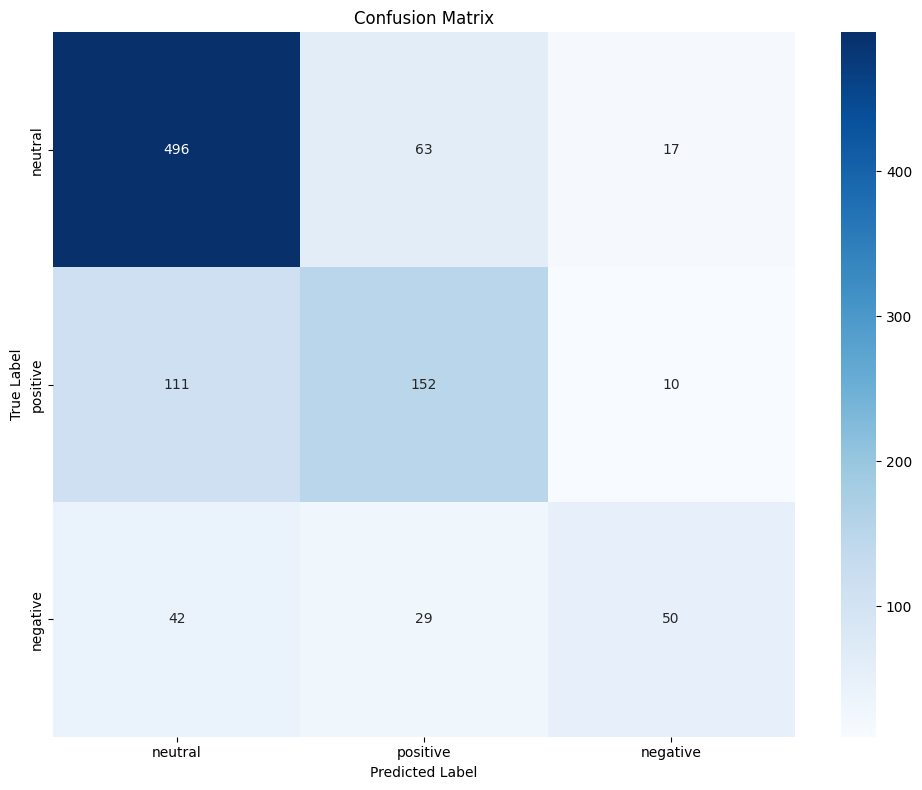

In [74]:
# Predictions
y_pred = log_reg.predict(X_test)

# Print classification report
target_names = ['neutral', 'positive', 'negative']
print(classification_report(y_test, y_pred, target_names=target_names))

plot_confusion_matrix(y_test, y_pred, target_names=target_names)


### Step 9: Make Predictions on New Data
- Use the trained model to predict the sentiment of new, unseen text

In [75]:
def predict_sentiment_text(text, model, log_reg_model):
    clean_text = preprocess_text(text)
    if IS_USE_KEY_VECTORS:
        doc_vec = document_vector_from_keyvector(model, word_tokenize(clean_text))
    else:
        doc_vec = document_vector_from_model(model, word_tokenize(clean_text))
    # Reshape for single sample prediction
    doc_vec = doc_vec.reshape(1, -1) 
    prediction = log_reg_model.predict(doc_vec)
    sentiment_map = {0: 'neutral', 1: 'positive', 2: 'negative'}
    return sentiment_map[prediction[0]]




In [79]:
if IS_USE_KEY_VECTORS:
    model = key_vectors_w2v
else:
    model = model_w2v

# Example
new_texts = [
                "Profit for the company has increased in this period",
                "Profit for the company has decreased in this period",
                "Market colour is mixed",
                "Microsoft just announced its Q1 earnings which has worried its share holders"
            ]
for idx, new_text in enumerate(new_texts):
    print(f"Sentiment for query {idx} is: {predict_sentiment_text(new_text, model, log_reg)}")

Sentiment for query 0 is: positive
Sentiment for query 1 is: negative
Sentiment for query 2 is: neutral
Sentiment for query 3 is: negative
